In [1]:
from pandas_datareader import data, wb

In [2]:
tickers_data = {}

In [3]:
from tqdm import tqdm

tickers = ['APBR', 'PAMP', 'YPFD', 'GGAL', 'ERAR', 'CRES', 'COME', 'ALUA', 'FRAN', 'MIRG',
'BMA', 'TRAN', 'TS', 'JMIN', 'EDN', 'TGSU2', 'SAMI', 'AGRO', 'TECO2', 'PESA',
'CEPU', 'CTIO', 'CECO2', 'AUSO', 'PETR', 'CELU', 'TGNO4']


for ticker in tqdm(tickers):
    if ticker in tickers_data: continue
        
    for method in 'get_data_google get_data_yahoo'.split():
        try:
            tickers_data[ticker] = {
                'source': method,
                'data': getattr(data, method)(ticker)
            }
        except Exception:
            continue


100%|██████████| 27/27 [01:40<00:00,  3.42s/it]


In [4]:
import pickle
with open('tickers_data.pkl', 'w') as f:
    pickle.dump(tickers_data, f, 2)

In [5]:
%matplotlib nbagg

%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


/Library/Python/2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [98]:
from statsmodels.tsa.filters.hp_filter import hpfilter

returns = []
for ticker, ticker_data in tickers_data.iteritems():
    close = ticker_data['data']['2017-01-01':].Close
    if len(close) == 0: continue
        
    returns.append(
        {
            'return': (close.iloc[-1] - close.iloc[0]) / close.iloc[0],
            'close': hpfilter(close, 50)[1],
            'close_orig': close,
            'ticker': ticker
        }    
    )


<IPython.core.display.Javascript object>


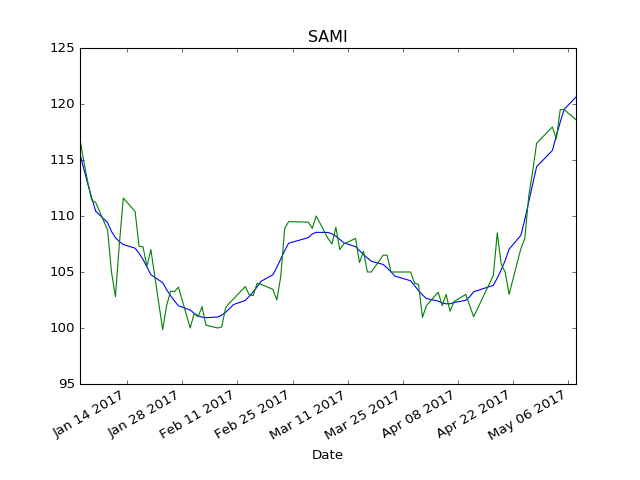

In [99]:
figure()
t = choice(returns)
title(t['ticker'])
t['close'].plot()
t['close_orig'].plot()

In [100]:
def corr(s1, s2, start):
    s1 = s1[start:]
    s2 = s2[start:]
    
#     return (s1 / s1.iloc[0]).corr(s2 / s2.iloc[0])
    return (s1 / s1.iloc[0]).diff().corr((s2 / s2.iloc[0]).diff())

corrs = []
for t1 in returns:
    for t2 in returns:
        corrs.append(
            {
                't1': t1['ticker'],
                't2': t2['ticker'],
                'corr': corr(t1['close'], t2['close'], '2016-01-01')
            }
        )

In [101]:
import pandas as pd
returns = pd.DataFrame(returns)
returns.sort_values('return', ascending=False)[['ticker', 'return']]

,ticker,return
8,TGNO4,0.786207
18,PESA,0.568966
3,PAMP,0.543103
24,AUSO,0.537234
10,GGAL,0.482124
23,TGSU2,0.444270
0,YPFD,0.366300
7,BMA,0.265382
15,CECO2,0.263158
17,COME,0.254902


In [102]:
corrs = pd.DataFrame(corrs)
corrs = corrs.sort_values('corr', ascending=False)
corrs[corrs.t1 == 'PAMP'].merge(returns, left_on='t2', right_on='ticker')[['t2', 'corr', 'return']]

,t2,corr,return
0,PAMP,1.000000,0.543103
1,PESA,0.976001,0.568966
2,YPFD,0.743478,0.366300
3,TS,0.708021,-0.137315
4,EDN,0.487973,0.163116
5,PETR,0.441737,-0.745136
6,ALUA,0.440038,0.082524
7,GGAL,0.349228,0.482124
8,JMIN,0.311200,0.153846
9,APBR,0.296299,-0.110138


<IPython.core.display.Javascript object>


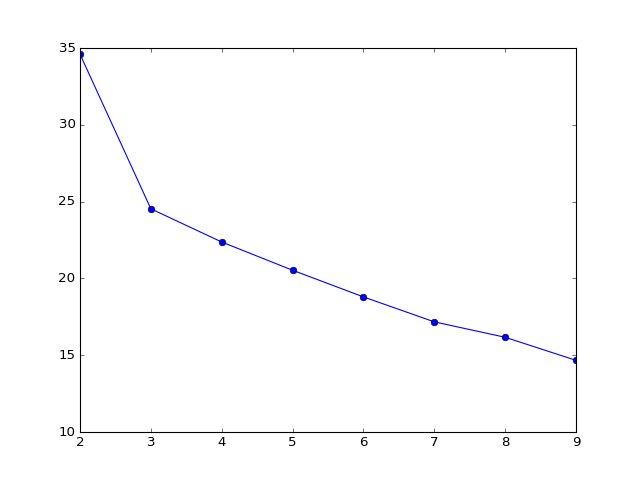

In [104]:
from sklearn.cluster import k_means
figure()
plot(range(2, 10), [k_means(M, i)[-1] for i in range(2, 10)], '-o')

In [105]:
from sklearn.cluster import k_means
clusters = dict(zip(names, k_means(M, 5)[1]))


In [112]:
from collections import defaultdict

names = sorted(corrs.t1.unique(), key=lambda x:corrs['corr'][corrs.t1==x].sum())
if 'avg_cluster_distance' in globals():
    avg_cluster_distance = defaultdict(list)
    for name, cl_id in clusters.iteritems():
        avg_cluster_distance[cl_id].append(corrs['corr'][corrs.t1==name].sum())
    avg_cluster_distance = {cl_id: np.mean(v) for cl_id, v in avg_cluster_distance.iteritems()}

    names = sorted(names, key=lambda x:avg_cluster_distance[clusters[x]])
    
M = []

for name1 in names:
    row = []
    for name2 in names:
        if name1 == name2:
            row.append(0)
        else:
            c = corrs[(corrs.t1 == name1) & (corrs.t2==name2)]
            row.append(c['corr'].iloc[0])
            
        
    M.append(row)
    

<IPython.core.display.Javascript object>


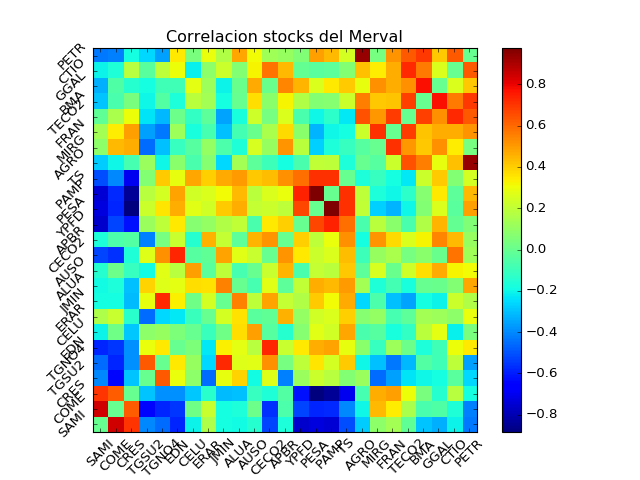

In [111]:
figure()
imshow(M, interpolation='nearest', origin='lower')
xticks(range(len(names)), names, rotation=45)
yticks(range(len(names)), names, rotation=45)

colorbar()
title('Correlacion stocks del Merval')

In [109]:
import networkx as nx
edges = []

for i, row in corrs.iterrows():
    if row['corr'] > 0:
        edges.append((row.t1, row.t2, round(float(row['corr']), 2)))
        
g = nx.Graph()
g.add_weighted_edges_from(edges)

In [110]:
nx.write_graphml(g, 'g.graphml')

In [95]:
!pwd

/Users/przivic/prog


<IPython.core.display.Javascript object>


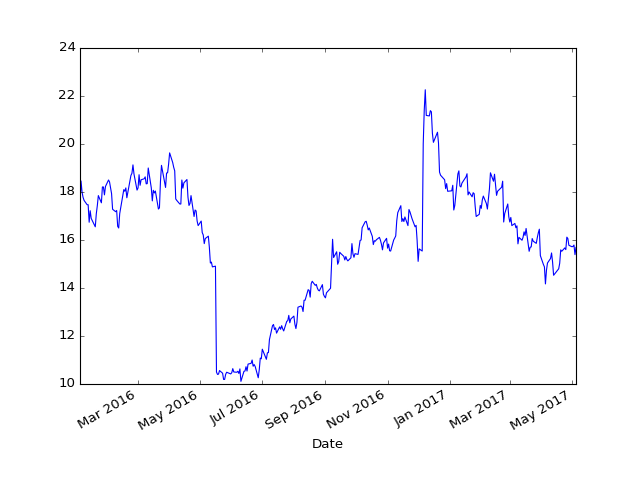

In [114]:
figure()
tickers_data['FRAN']['data']['2016-01-01':].Close.plot()